<a href="https://colab.research.google.com/github/renanpyd/Course_Google_Colab/blob/main/site/pt-br/tutorials/keras/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Classificação de texto com avaliações de filmes

Note: A nossa comunidade TensorFlow traduziu estes documentos. Como as traduções da comunidade são *o melhor esforço*, não há garantias de que sejam uma reflexão exata e atualizada da [documentação oficial em Inglês](https://www.tensorflow.org/?hl=en). Se tem alguma sugestão para melhorar esta tradução, por favor envie um pull request para o repositório do GitHub [tensorflow/docs](https://github.com/tensorflow/docs). Para se voluntariar para escrever ou rever as traduções da comunidade, contacte a [lista docs@tensorflow.org](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs).

Este *notebook* classifica avaliações de filmes como **positiva** ou **negativa** usando o texto da avaliação. Isto é um exemplo de classificação *binária* —ou duas-classes—, um importante e bastante aplicado tipo de problema de aprendizado de máquina.

Usaremos a base de dados [IMDB](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) que contém avaliaçòes de mais de 50000 filmes da base de dados [Internet Movie Database](https://www.imdb.com/). A base é dividida em 25000 avaliações para treinamento e 25000 para teste. Os conjuntos de treinamentos e testes são *balanceados*, ou seja, eles possuem a mesma quantidade de avaliações positivas e negativas.

O notebook utiliza [tf.keras](https://www.tensorflow.org/guide/keras), uma API alto-nível para construir e treinar modelos com TensorFlow. Para mais tutoriais avançados de classificação de textos usando `tf.keras`, veja em [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.7.0


## Baixe a base de dados IMDB

A base de dados vem empacotada com TensorFlow. Ela já vem pré-processada de forma que as avaliações (sequências de palavras) foram convertidas em sequências de inteiros, onde cada inteiro representa uma palavra específica no dicionário.

O código abaixo baixa a base de dados IMDB para a sua máquina (ou usa a cópia em *cache*, caso já tenha baixado):"

In [4]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 0s 0us/step


O argumento `num_words=10000` mantém as 10000 palavras mais frequentes no conjunto de treinamento. As palavras mais raras são descartadas para preservar o tamanho dos dados de forma maleável.

##  Explore os dados

Vamos parar um momento para entender o formato dos dados. O conjunto de dados vem pré-processado: cada exemplo é um *array* de inteiros representando as palavras da avaliação do filme. Cada *label*  é um inteiro com valor ou de 0 ou 1, onde 0 é uma avaliação negativa e 1 é uma avaliação positiva.

In [5]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


O texto das avaliações foi convertido para inteiros, onde cada inteiro representa uma palavra específica no dicionário. Isso é como se parece a primeira revisão:

In [6]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


As avaliações dos filmes têm tamanhos diferentes. O código abaixo mostra o número de palavras da primeira e segunda avaliação. Sabendo que o número de entradas da rede neural tem que ser o mesmo também, temos que resolver isto mais tarde.

In [7]:
len(train_data[0]), len(train_data[1])

(218, 189)

### Converta os inteiros de volta a palavras

É útil saber como converter inteiros de volta a texto. Aqui, criaremos uma função de ajuda para consultar um objeto *dictionary* que contenha inteiros mapeados em strings:

In [8]:
# Um dicionário mapeando palavras em índices inteiros
word_index = imdb.get_word_index()

# Os primeiros índices são reservados
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1654784/1641221 [==============================] - 0s 0us/step


Agora, podemos usar a função `decode_review` para mostrar o texto da primeira avaliação:

In [9]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Prepare os dados

As avaliações —os *arrays* de inteiros— devem ser convertidas em tensores (*tensors*) antes de alimentar a rede neural. Essa conversão pode ser feita de duas formas:

* Converter os arrays em vetores de 0s e 1s indicando a ocorrência da palavra, similar com one-hot encoding. Por exemplo, a sequência [3, 5] se tornaria um vetor de 10000 dimensões, onde todos seriam 0s, tirando 3 e 5, que são 1s. Depois, faça disso a primeira camada da nossa rede neural — a Dense layer — que pode trabalhar com dados em ponto flutuante. Essa abordagem é intensa em relação a memória, logo requer uma matriz de tamanho `num_words * num_reviews`.

* Alternativamente, podemos preencher o array para que todos tenho o mesmo comprimento, e depois criar um tensor inteiro de formato `max_length * num_reviews`. Podemos usar uma camada *embedding* capaz de lidar com o formato como a primeira camada da nossa rede.

Nesse tutorial, usaremos a segunda abordagem.

Já que as avaliações dos filmes devem ter o mesmo tamanho, usaremos a função [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) para padronizar os tamanhos:

In [10]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Agora, vamos olhar o tamanho dos exemplos:

In [11]:
len(train_data[0]), len(train_data[1])

(256, 256)

E inspecionar as primeiras avaliações (agora preenchidos):

In [12]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## Construindo o modelo

A rede neural é criada por camadas empilhadas —isso necessita duas decisões arquiteturais principais:

* Quantas camadas serão usadas no modelo?
* Quantas *hidden units*  são usadas em cada camada?

Neste exemplo, os dados de entrada são um *array* de palavras-índices. As *labels*  para predizer são ou 0 ou 1. Vamos construir um modelo para este problema:

In [13]:
# O formato de entrada é a contagem vocabulário usados pelas avaliações dos filmes (10000 palavras)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


As camadas são empilhadas sequencialmente para construir o classificador:

1. A primeira camada é uma camada `Embedding` (*`Embedding` layer*). Essa camada pega o vocabulário em inteiros e olha o vetor *embedding*  em cada palavra-index. Esses vetores são aprendidos pelo modelo, ao longo do treinamento. Os vetores adicionam a dimensão ao *array* de saída. As dimensões resultantes são: `(batch, sequence, embedding)`.
2. Depois, uma camada `GlobalAveragePooling1D` retorna um vetor de saída com comprimento fixo para cada exemplo fazendo a média da sequência da dimensão. Isso permite o modelo de lidar com entradas de tamanhos diferentes da maneira mais simples possível.
3. Esse vetor de saída com tamanho fixo passa por uma camada *fully-connected* (`Dense`) layer com 16 *hidden units*.
4. A última camada é uma *densely connected* com um único nó de saída. Usando uma função de ativação `sigmoid`, esse valor  é um float que  varia entre 0  e 1, representando a probabilidade, ou nível de confiança.

### Hidden units

O modelo abaixo tem duas camadas intermediárias ou _\"hidden\"_ (hidden layers), entre a entrada e saída. O número de saídas (unidades— *units*—, nós ou neurônios) é a dimensão do espaço representacional para a camada. Em outras palavras, a quantidade de liberdade que a rede é permitida enquanto aprende uma representação interna.

Se o modelo tem mais *hidden units* (um espaço representacional de maior dimensão), e/ou mais camadas, então a rede pode aprender representações mais complexas. Entretanto, isso faz com que a rede seja computacionalmente mais custosa e pode levar ao aprendizado de padrões não desejados— padrões que melhoram a performance com os dados de treinamento, mas não com os de teste. Isso se chama *overfitting*, e exploraremos mais tarde.

### Função Loss e otimizadores (optimizer)

O modelo precisa de uma função *loss* e um otimizador (*optimizer*) para treinamento. Já que é um problema de classificação binário e o modelo tem como saída uma probabilidade (uma única camada com ativação sigmoide), usaremos a função loss `binary_crossentropy`.

Essa não é a única escolha de função loss, você poderia escolher, no lugar, a `mean_squared_error`. Mas, geralmente, `binary_crossentropy` é melhor para tratar probabilidades— ela mede a \"distância\" entre as distribuições de probabilidade, ou, no nosso caso, sobre a distribuição real e as previsões.

Mais tarde, quando explorarmos problemas de regressão (como, predizer preço de uma casa), veremos como usar outra função loss chamada *mean squared error*.

Agora, configure o modelo para usar o *optimizer* a função loss:

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Crie um conjunto de validação

Quando treinamos. queremos checar a acurácia do modelo com os dados que ele nunca viu. Crie uma conjunto de *validação* tirando 10000 exemplos do conjunto de treinamento original. (Por que não usar o de teste agora? Nosso objetivo é desenvolver e melhorar (tunar) nosso modelo usando somente os dados de treinamento, depois de usar o teste uma única vez para avaliar a previsão).

In [15]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Treine o modelo

Treine o modelo em 40 *epochs* com *mini-batches* de 512 exemplos. Essas 40 iterações sobre todos os exemplos nos tensores `x_train` e `y_train`. Enquanto treina, monitore os valores do loss e da acurácia do modelo nos 10000 exemplos do conjunto de validação:

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 21ms/step - loss: 0.6909 - accuracy: 0.5849 - val_loss: 0.6878 - val_accuracy: 0.6470
Epoch 2/40
30/30 [==============================] - 0s 17ms/step - loss: 0.6824 - accuracy: 0.7047 - val_loss: 0.6767 - val_accuracy: 0.7379
Epoch 3/40
30/30 [==============================] - 0s 17ms/step - loss: 0.6662 - accuracy: 0.7567 - val_loss: 0.6569 - val_accuracy: 0.7527
Epoch 4/40
30/30 [==============================] - 0s 16ms/step - loss: 0.6395 - accuracy: 0.7759 - val_loss: 0.6276 - val_accuracy: 0.7737
Epoch 5/40
30/30 [==============================] - 0s 17ms/step - loss: 0.6018 - accuracy: 0.7967 - val_loss: 0.5886 - val_accuracy: 0.7916
Epoch 6/40
30/30 [==============================] - 1s 17ms/step - loss: 0.5559 - accuracy: 0.8189 - val_loss: 0.5446 - val_accuracy: 0.8095
Epoch 7/40
30/30 [==============================] - 0s 16ms/step - loss: 0.5069 - accuracy: 0.8376 - val_loss: 0.5014 - val_accuracy: 0.8167
Epoch 8/40
30

## Avalie o modelo

E vamos ver como o modelo se saiu. Dois valores serão retornados. Loss (um número que representa o nosso erro, valores mais baixos são melhores), e acurácia.

In [17]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3360 - accuracy: 0.8714 - 994ms/epoch - 1ms/step
[0.3360079228878021, 0.8714399933815002]


Esta é uma abordagem ingênua que conseguiu uma acurácia de 87%. Com abordagens mais avançadas, o modelo deve chegar em 95%.

## Crie um gráfico de acurácia e loss por tempo

`model.fit()` retorna um objeto `History` que contém um dicionário de tudo o que aconteceu durante o treinamento:

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Tem 4 entradas: uma para cada métrica monitorada durante a validação e treinamento. Podemos usá-las para plotar a comparação do loss de treinamento e validação, assim como a acurácia de treinamento e validação:

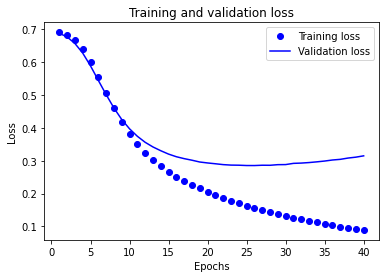

In [19]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

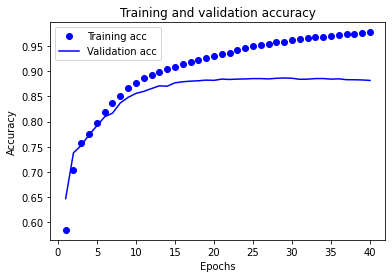

In [20]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

No gráfico, os pontos representam o loss e acurácia de treinamento, e as linhas são o loss e a acurácia de validação.

Note: que o loss de treinamento *diminui*  a cada *epoch*  e a acurácia *aumenta*. Isso é esperado quando usado um gradient descent optimization—ele deve minimizar a quantidade desejada a cada iteração.

Esse não é o caso do loss e da acurácia de validação— eles parecem ter um pico depois de 20 epochs. Isso é um exemplo de *overfitting*: o modelo desempenha melhor nos dados de treinamento do que quando usado com dados nunca vistos. Depois desse ponto, o modelo otimiza além da conta e aprende uma representação *especifica* para os dados de treinamento e não *generaliza* para os dados de teste.

Para esse caso particular, podemos prevenir o *overfitting* simplesmente parando o treinamento após mais ou menos 20 epochs. Depois, você verá como fazer isso automaticamente com um *callback*.